rpm_max =  2014.901579543395
continuous model
a =  [[-66.66666667]]
b =  [[14066.66666667]]



<Figure size 640x480 with 0 Axes>

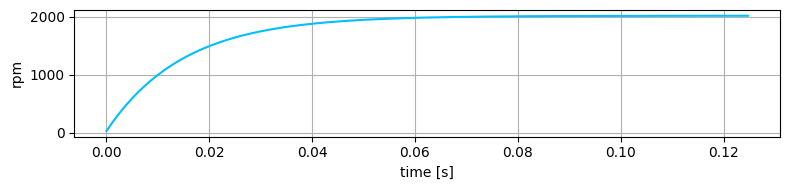

In [47]:
import LibsControl
import numpy
import matplotlib.pyplot as plt

#parameters from identification

#sampling frequency, 4kHz
dt       = 1.0/4000.0


'''
u_max       = 1.0
k           = 80.818    # motor constant 
rad_var     = 12.788    # (rad/s)^2 variance (encoder noise)
tau         = 9.876     # motor time constant, milliseconds
'''

'''
u_max       = 1.0       # motor max input range
k           = 139.084   # motor constant 
rad_var     = 140.463   # (rad/s)^2 variance (encoder noise)
tau         = 8.276     # motor time constant, milliseconds
'''

'''
u_max       = 1.0
k          =  206.924
rad_var     =  1.438
tau         =  18.461
'''

'''
u_max       = 1.0
k          =  206.924
rad_var     =  1.438
#tau         =  18.461
tau         =  34
'''

u_max       = 1.0
k           =  211
rad_var     =  1.438
tau         =  15





rpm_max = u_max*k*60.0/(2.0*numpy.pi)

print("rpm_max = ", rpm_max)


#continuous time dynamics
mat_a = numpy.zeros((1, 1))
mat_b = numpy.zeros((1, 1))
mat_c = numpy.eye(1)
 
tau = tau*0.001
mat_a[0][0] = -1.0/tau    
mat_b[0][0] = k*(1.0/tau)


print("continuous model")
print("a = ", mat_a)
print("b = ", mat_b)
print()


#create dynamical system
ds = LibsControl.DynamicalSystem(mat_a, mat_b, mat_c, dt)


#compute step response
t_result = []
u_result = []
x_result = []


for n in range(500):

    # unit step as input
    u = numpy.ones((1, 1))

    x, _ = ds.forward_state(u)

    t_result.append(n*dt)
    x_result.append(x[:, 0])

t_result = numpy.array(t_result)
x_result = numpy.array(x_result)

#plot result
LibsControl.plot_open_loop_response(t_result, x_result*60.0/(2.0*numpy.pi), file_name = "step_response.png", labels = ["rpm"])




In [48]:


#create loss weighting matrices (diagonal)
q = numpy.array([ [1.0] ] )
r = numpy.array( [ [10**7] ]) 

#process and observation noise covariance
q_noise = 0.5*numpy.eye(ds.a.shape[0]) 
r_noise = rad_var*numpy.eye(ds.c.shape[0]) 
 

a_disc, b_disc, c_disc = LibsControl.c2d(ds.a, ds.b, ds.c, dt)

print("discrete model")
print("a = ", a_disc)
print("b = ", b_disc)
#print()
#print("poles")
#print(numpy.linalg.eigvals(a_disc))
print("\n")

#solve LQG controller
lqg = LibsControl.LQGDiscrete(a_disc, b_disc, c_disc, q, r, q_noise, r_noise)

print("controller")
print("k  = ", lqg.k)
print("ki = ", lqg.ki)
print("f  = ", lqg.f)




discrete model
a =  [[0.98347107]]
b =  [[3.48760331]]


controller
k  =  [[0.0097251]]
ki =  [[0.00032155]]
f  =  [[0.43432103]]


<Figure size 640x480 with 0 Axes>

<Figure size 800x400 with 0 Axes>

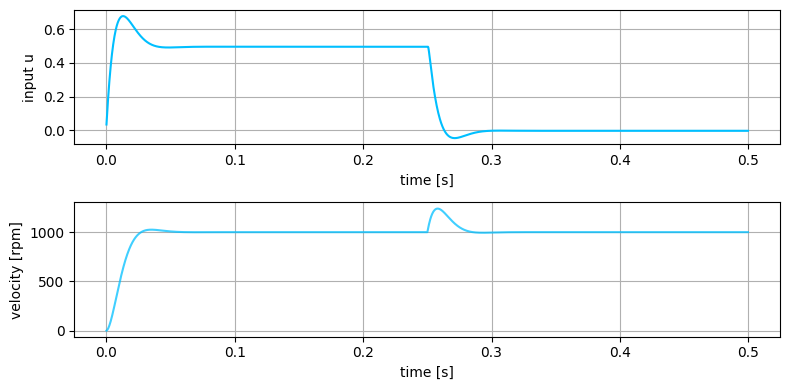

In [49]:

#process simulation

n_max = 2000

#required output, 1000rpm
rpm_req = 1000

yr = numpy.zeros((mat_c.shape[0], 1))
yr[0][0] = (rpm_req/60.0)*(2.0*numpy.pi) 


#observed state
x_hat = numpy.zeros((mat_a.shape[0], 1))



#initial error integral
integral_action = numpy.zeros((mat_b.shape[1], 1))

#result log
t_result = []
u_result = []
u_in_result = []
x_result = []



#initial motor state
ds.reset()

#plant output
y = ds.y

for n in range(n_max):

    #compute controller output
    u, integral_action, x_hat = lqg.forward(yr, y, integral_action, x_hat)
    
    u_in = u.copy()

    #add constant disturbance in middle
    if n > n_max//2:
        u_in[0]+= 0.5
 
    #compute plant output
    x, y = ds.forward_state(u_in)
  
    

    t_result.append(n*dt)
    u_result.append(u[:, 0].copy())
    u_in_result.append(u_in[:, 0].copy())
    x_result.append(x[:, 0].copy())

    
    
t_result = numpy.array(t_result)
x_result = numpy.array(x_result)
u_result = numpy.array(u_result)
u_in_result = numpy.array(u_in_result)

#convert rps to rpm
x_result[:, 0]*= 60.0/(2.0*numpy.pi)

#plot results
LibsControl.plot_closed_loop_response(t_result, u_in_result, x_result, x_hat = None, file_name = "lqg_discrete_output.png", u_labels = ["input u"], x_labels = ["velocity [rpm]"])
LibsControl.plot_closed_loop_response(t_result, u_result, x_result, x_hat = None, file_name = "lqg_discrete_output.png", u_labels = ["input u"], x_labels = ["velocity [rpm]"])
